# VMStat Performance Analysis

This notebook parses `vmstat` output logs and visualizes system metrics. It is designed to compare multiple `vmstat` runs by aligning them on a relative time axis (seconds elapsed).

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io

# Apply a modern plotting theme
sns.set_theme(style="whitegrid")

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

def parse_vmstat_file(filepath):
    """
    Parses a single vmstat file, handling repeated headers and non-numeric rows.
    """
    # Define standard vmstat columns + date/time
    columns = [
        "r", "b", "swpd", "free", "buff", "cache", "si", "so", "bi", "bo", 
        "in", "cs", "us", "sy", "id", "wa", "st", "gu", "date", "time"
    ]
    
    # Read entire file as string to handle varying header positions
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Filter out header lines (lines starting with non-numeric chars typically found in headers)
    # We look for lines that strictly do not start with 'procs' or 'r' and have enough columns.
    # A safer way: Try to parse, then coerce errors.
    
    data_lines = []
    for line in lines:
        parts = line.split()
        # skip lines that are clearly headers or separator lines
        if not parts or parts[0] in ['procs', 'r', '-----------memory----------']:
            continue
        # simple check: valid data lines usually start with a digit
        if parts[0].isdigit():
            data_lines.append(parts)

    if not data_lines:
        return pd.DataFrame()

    df = pd.DataFrame(data_lines, columns=columns)
    
    # Convert numeric columns
    numeric_cols = columns[:-2] # All except date and time
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
    # Drop any rows that failed conversion (just in case)
    df.dropna(subset=numeric_cols, inplace=True)

    # Combine date and time
    df["timestamp"] = pd.to_datetime(df["date"] + " " + df["time"])
    
    # Calculate relative time (elapsed seconds) from the start of this specific file
    start_time = df["timestamp"].min()
    df["elapsed_seconds"] = (df["timestamp"] - start_time).dt.total_seconds()
    
    return df

def analyze_directory(directory_path, metric_to_plot="free"):
    """
    Reads all files in the directory and plots the comparison.
    """
    dir_path = Path(directory_path)
    if not dir_path.exists():
        print(f"Error: Directory {directory_path} not found.")
        return

    combined_data = []
    
    # Iterate over all files (assuming they are text/log files)
    # Adjust the glob pattern if files have a specific extension, e.g., '*.log'
    files = sorted(dir_path.glob("*load_pandas_*"))
    
    for file in files:
        if file.is_file():
            try:
                print(f"Processing {file.name}...")
                df = parse_vmstat_file(file)
                if not df.empty:
                    df["run_id"] = file.name # Use filename as the label
                    combined_data.append(df)
            except Exception as e:
                print(f"Skipping {file.name}: {e}")

    if not combined_data:
        print("No valid data found to plot.")
        return

    # reset_index is crucial here to avoid 'duplicate labels' error during concat
    # if the individual dataframes have conflicting indices.
    final_df = pd.concat(combined_data).reset_index(drop=True)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=final_df, 
        x="elapsed_seconds", 
        y=metric_to_plot, 
        hue="run_id", 
        marker="."
    )
    
    plt.title(f"Comparison of '{metric_to_plot}' across files")
    plt.xlabel("Elapsed Time (seconds)")
    plt.ylabel(metric_to_plot)
    plt.tight_layout()
    plt.show()



Processing vmstat_load_pandas_json.py.log...
Processing vmstat_load_pandas_jsonl.py.log...


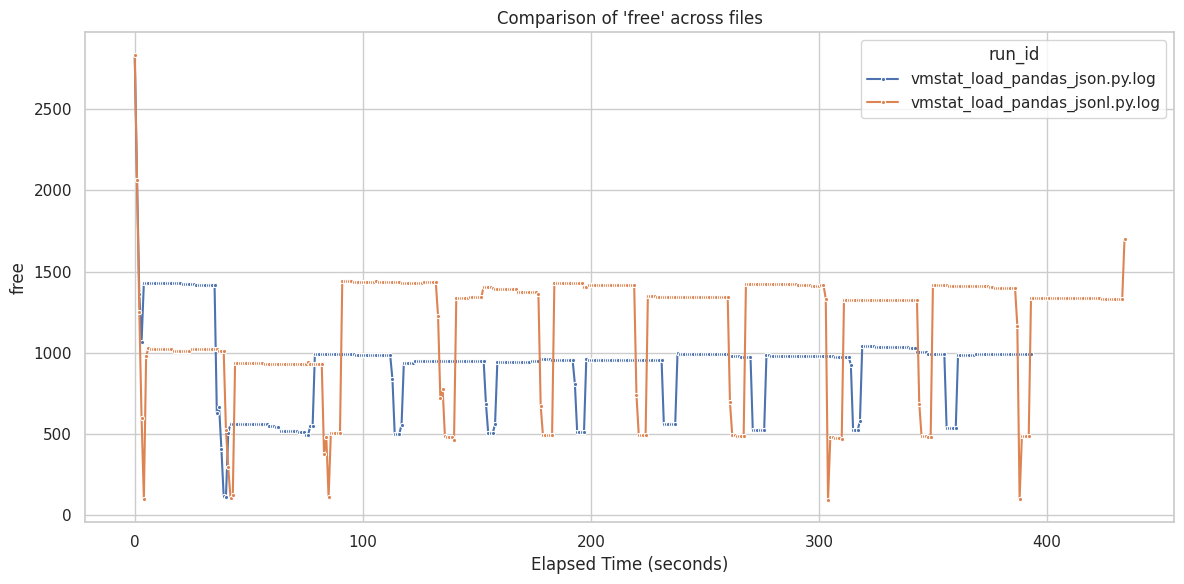

Processing vmstat_load_pandas_json.py.log...
Processing vmstat_load_pandas_jsonl.py.log...


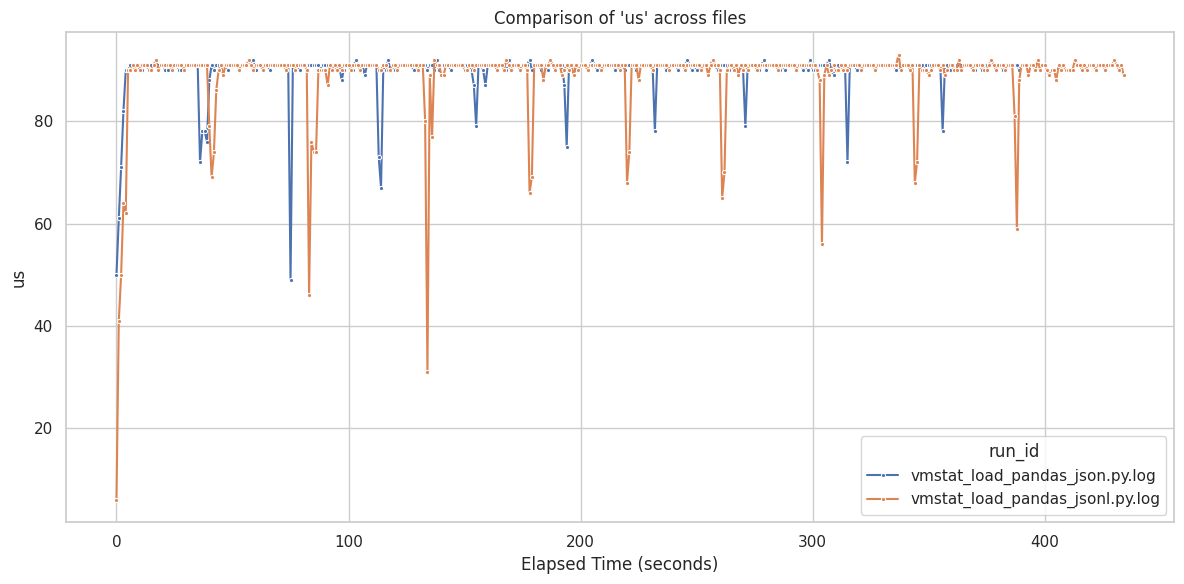

In [7]:
# Compare 'free' memory usage across the two runs
analyze_directory("sample_outputs/vmstat/", metric_to_plot="free")

# Compare 'us' (user cpu) usage
analyze_directory("sample_outputs/vmstat/", metric_to_plot="us")